# This is the minimum Working Example to compute a multiple scattering experiment in the Q-Phase 

In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 10 19:53:32 2017

@author: Bene

This file creates a fwd-model for the TESCAN Q-PHASE under 
multiple-scattering. It is majorly derived from  "LEarning approach for optical tomography"
U. S. Kamilov, BIG, EPFL, 2014.
"""
# %load_ext autoreload
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from datetime import datetime

# load own functions
import src.model as mus
import src.tf_helper as tf_helper
import src.tf_generate_object as tf_go
import src.data as data
import src.optimization.tf_regularizers as reg

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 7))
mpl.rc('image', cmap='gray')


# Define some optimization parameters 

In [2]:
'''Define some stuff related to infrastructure'''
mytimestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
savepath = os.path.join('./Data/DROPLETS/RESULTS/', mytimestamp)

# Create directory
try: 
    os.mkdir(savepath)
except(FileExistsError): 
    print('Folder exists already')

# Define parameters 
is_padding = False 
is_display = True
is_optimization = True 
is_optimization_psf = True
is_flip = False
is_measurement = True

# data files for parameters and measuremets 
if is_measurement:
    if(False):
        matlab_val_file = './Data/DROPLETS/allAmp_red.mat'      #'./Data/DROPLETS/allAmp_simu.npy' #
        matlab_par_file = './Data/DROPLETS/myParameterNew.mat'   
        matlab_val_name = 'allAmp_red'
        matlab_par_name = 'myParameterNew'  
    if(True):
        matlab_val_file = './Data/DROPLETS/S19_multiple/S19_subroi2.mat'      #'./Data/DROPLETS/allAmp_simu.npy' #
        matlab_par_file = './Data/DROPLETS/S19_multiple/Parameter.mat'   
        matlab_val_name = 'allAmp_red'
        matlab_par_name = 'myParameter' 
        
else:
    matlab_val_file = './Data/DROPLETS/RESULTS/allAmp_simu.npy' #'./Data/DROPLETS/allAmp_simu.mat'      
    matlab_par_file = './Data/DROPLETS/myParameterNew.mat' 
    matlab_val_name = 'allAmp_red'
    matlab_par_name = 'myParameterNew'

# microscope parameters
zernikefactors = np.array((0,0,0,0,0,0,0.,-0.,0)) # representing the 9 first zernike coefficients in noll-writings 
shiftIcY=-1
shiftIcX=-0
dn = .1
NAc = .52

'''Define Optimization Parameters'''
my_learningrate = 1e-2  # learning rate
lambda_tv =  1e-2 # lambda for Total variation
epsTV = .01
lambda_gr = 0 # lambda for Goods Roughness 
lambda_pos = 0
lambda_neg = 10

Niter = 10000
Ndisplay = 15


'''START CODE'''
tf.reset_default_graph() # just in case there was an open session

# Generate Test-Object

In [3]:
''' File which stores the experimental parameters from the Q-PHASE setup 
    1.) Read in the parameters of the dataset ''' 
matlab_pars = data.import_parameters_mat(filename = matlab_par_file, matname=matlab_par_name)

''' 2.) Read in the parameters of the dataset ''' 
if(matlab_val_file.find('mat')==-1):
    matlab_val = np.load(matlab_val_file)
else:
    matlab_val = data.import_realdata_h5(filename = matlab_val_file, matname=matlab_val_name, is_complex=True)

if(is_flip):
    np_meas_raw = np.flip(matlab_val,0)
    print('Attention: We are flipping the data!')
else:
    np_meas_raw = matlab_val
    print('do we need to flip the data?! -> Observe FFT!!')



''' Create the Model'''
muscat = mus.MuScatModel(matlab_pars, is_optimization=is_optimization, is_optimization_psf = is_optimization_psf)
muscat.Nx,muscat.Ny = int(np.squeeze(matlab_pars['Nx'].value)), int(np.squeeze(matlab_pars['Ny'].value))
muscat.shiftIcY=shiftIcY
muscat.shiftIcX=shiftIcX
muscat.dn = dn
muscat.NAc = NAc
muscat.dz = muscat.lambda0/4

print('Attention: Changed Z-sampling!!')

''' Adjust some parameters to fit it in the memory '''
muscat.mysize = (muscat.Nz,muscat.Nx,muscat.Ny) # ordering is (Nillu, Nz, Nx, Ny)

''' Create a 3D Refractive Index Distributaton as a artificial sample'''
obj = tf_go.generateObject(mysize=muscat.mysize, obj_dim=(muscat.dz,muscat.dx,muscat.dy), obj_type ='sphere', diameter = 1, dn = muscat.dn)
obj = obj+1j*obj
# introduce zernike factors here
muscat.zernikefactors = zernikefactors


do we need to flip the data?! -> Observe FFT!!
Assigned some value for dn which is not good!
Attention: Changed Z-sampling!!


# Compute the System's properties (e.g. Pupil function/Illumination Source, K-vectors, etc.)

In [4]:
''' Compute the systems model'''
muscat.computesys(obj, is_zernike=True, is_padding=is_padding, dropout_prob=1)
tf_fwd = muscat.computemodel()

----------> Be aware: We are taking aberrations into account!
We are weighing the Intensity int the illu-pupil!
Shifting the illumination in X by: 0 Pixel
Shifting the illumination in Y by: -1 Pixel
Number of Illumination Angles / Plane waves: 49
Buildup Q-PHASE Model 


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:416: ComplexWarning: Casting complex values to real discards the imaginary part
  nparray = values.astype(dtype.as_numpy_dtype)


# Define Optimizer and Cost-function

Now load data which has been saved previously (Optional!)

Evtl unwrap it!


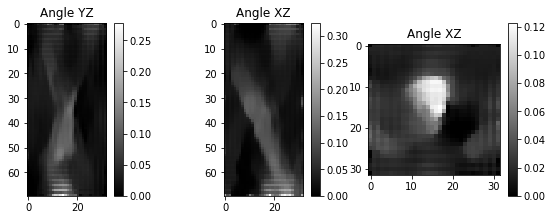

In [5]:
print('Evtl unwrap it!')

# this is the initial guess of the reconstruction
np_meas=np_meas_raw#*np.exp(1j*np.pi)


if(False): # good for the experiment
    init_guess = np.angle(np_meas)
    init_guess = init_guess - np.min(init_guess)
    init_guess = init_guess**2
    init_guess = init_guess/np.max(init_guess)*muscat.dn
elif(False): # good for the simulation
    init_guess = -np.abs(np_meas)
    init_guess = init_guess - np.min(init_guess)
    init_guess = init_guess**2
    init_guess = init_guess/np.max(init_guess)*muscat.dn
    init_guess = np.flip(init_guess,0)
elif(False):
    init_guess = np.ones(np_meas.shape)*muscat.dn
elif(False):
    init_guess = tf_go.generateObject(mysize=muscat.mysize, obj_dim=muscat.dx, obj_type ='sphere', diameter = 7, dn = muscat.dn)
else:
    init_guess = np_meas
    obj = tf_go.generateObject(mysize=muscat.mysize, obj_dim=muscat.dx, obj_type ='sphere', diameter = 10, dn = muscat.dn)
    obj_absorption = tf_go.generateObject(mysize=muscat.mysize, obj_dim=muscat.dx, obj_type ='sphere', diameter = 10, dn = 1)
    obj = obj+1j*obj_absorption*.2
    init_guess = obj
    init_guess = np.load('my_res_cmplx.npy')
    #init_guess = np.random.randn(np_meas.shape[0],init_guess.shape[1],init_guess.shape[2])*muscat.dn

        

if(is_display): plt.subplot(231), plt.title('Angle YZ'),plt.imshow(np.real(init_guess[:,init_guess.shape[1]//2,:])), plt.colorbar()
if(is_display): plt.subplot(232), plt.title('Angle XZ'),plt.imshow(np.real(init_guess[:,:,init_guess.shape[1]//2])), plt.colorbar()
if(is_display): plt.subplot(233), plt.title('Angle XZ'),plt.imshow(np.real(init_guess[init_guess.shape[0]//2,:,:])), plt.colorbar(),plt.show()


# Set Optimization Parameters

In [6]:
@tf.custom_gradient
def clip_grad_layer(x):
    def grad(dy):
        return tf.clip_by_value(dy, -5, 5)
    return tf.identity(x), grad

'''Regression + Regularization'''
tf_meas = tf.placeholder(dtype=tf.complex64, shape=init_guess.shape)
             
'''Define Cost-function'''
tf_lambda_tv = tf.placeholder(tf.float32, [])
#tf_tvloss = tf_lambda_tv*reg.tf_total_variation_regularization(muscat.TF_obj, BetaVals = [muscat.dx,muscat.dy,muscat.dz], epsR=epsTV, is_circ = True)  #Alernatively tf_total_variation_regularization # total_variation
tf_tvloss = tf_lambda_tv*reg.total_variation_iso_conv(muscat.TF_obj,  eps=epsTV, step_sizes = [muscat.dx,muscat.dy,muscat.dz])  #Alernatively tf_total_variation_regularization # total_variation
tf_tvloss += tf_lambda_tv*reg.total_variation_iso_conv(muscat.TF_obj_absorption,  eps=epsTV, step_sizes = [muscat.dx,muscat.dy,muscat.dz])  #Alernatively tf_total_variation_regularization # total_variation

tf_negsqrloss = lambda_neg*reg.RegularizeNegSqr(muscat.TF_obj)
tf_globalphase = tf.Variable(0., tf.float32, name='var_phase')
tf_globalabs = tf.Variable(1., tf.float32, name='var_abs')# 
tf_fidelity = tf.reduce_sum((tf_helper.tf_abssqr(tf_fwd  - (tf_meas/tf.cast(tf.abs(tf_globalabs), tf.complex64)*tf.exp(1j*tf.cast(tf_globalphase, tf.complex64)))))) # allow a global phase parameter to avoid unwrapping effects
#tf_fidelity = clip_grad_layer(tf_fidelity)
tf_grads = tf.gradients(tf_fidelity, [muscat.TF_obj])[0]

tf_loss = tf_fidelity +  tf_negsqrloss + tf_tvloss #tf_negloss + tf_posloss + tf_tvloss

 # data fidelity
# TV regularization
# Positivity Penalty          
# eventually Goods Roughness reg
'''Define Optimizer'''
tf_learningrate = tf.placeholder(tf.float32, []) 
tf_optimizer = tf.train.AdamOptimizer(tf_learningrate)
if(False):
    gradients, variables = zip(*tf_optimizer.compute_gradients(tf_loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
    tf_lossop = tf_optimizer.apply_gradients(zip(gradients, variables))

#tf_optimizer = tf.train.MomentumOptimizer(tf_learningrate, momentum = .9, use_nesterov=True)
#tf_optimizer = tf.train.ProximalGradientDescentOptimizer(tf_learningrate)
else:
    tf_lossop = tf_optimizer.minimize(tf_loss)

    
''' Evaluate the model '''
sess = tf.Session()#config=tf.ConfigProto(allow_growth=True))#config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())
if is_optimization:
    if is_padding:
        # Pad object with zeros along X/Y
        init_guess_tmp= np.zeros(muscat.mysize)# + 1j*np.zeros(muscat.mysize)
        init_guess_tmp[:,muscat.Nx//2-muscat.Nx//4:muscat.Nx//2+muscat.Nx//4, muscat.Ny//2-muscat.Ny//4:muscat.Ny//2+muscat.Ny//4] =init_guess
        init_guess = init_guess_tmp

    sess.run(tf.assign(muscat.TF_obj, init_guess)); # assign abs of measurement as initial guess of 

my_fwd = sess.run(tf_fwd)#, feed_dict={muscat.TF_obj:obj})
mysize = my_fwd.shape



C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:416: ComplexWarning: Casting complex values to real discards the imaginary part
  nparray = values.astype(dtype.as_numpy_dtype)


InternalError: BlasScal failed : in.shape=[49,32,32]
	 [[{{node Fwd_Propagate/Propagate/IFFT2D}} = IFFT2D[Tcomplex=DT_COMPLEX64, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Fwd_Propagate/Propagate/mul)]]
	 [[{{node Back_Propagate/Back_Propagate_Step_20/Adjust/strided_slice_2/_43}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2142_Back_Propagate/Back_Propagate_Step_20/Adjust/strided_slice_2", tensor_type=DT_COMPLEX64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Fwd_Propagate/Propagate/IFFT2D', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-3abb202ba7e9>", line 3, in <module>
    tf_fwd = muscat.computemodel()
  File "C:\Users\diederichbenedict\Dropbox\Dokumente\Promotion\PROJECTS\BOSTON\MUSCAT\PYTHON\muScat\src\model.py", line 282, in computemodel
    self.TF_A_prop = tf.ifft2d(tf.fft2d(self.TF_A_prop) * self.TF_myprop) # diffraction step
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_spectral_ops.py", line 618, in ifft2d
    "IFFT2D", input=input, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3272, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InternalError (see above for traceback): BlasScal failed : in.shape=[49,32,32]
	 [[{{node Fwd_Propagate/Propagate/IFFT2D}} = IFFT2D[Tcomplex=DT_COMPLEX64, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Fwd_Propagate/Propagate/mul)]]
	 [[{{node Back_Propagate/Back_Propagate_Step_20/Adjust/strided_slice_2/_43}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2142_Back_Propagate/Back_Propagate_Step_20/Adjust/strided_slice_2", tensor_type=DT_COMPLEX64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


# Estimate the Phase difference between Measurement and Simulation

In [ ]:
# We assume, that there is a global phase mismatch between measurment and first estimate of the fwd model, this can be estimated by the difference of mean phase of the two
# subtracting the mean phase from either measurement or the fwd model could help to speed up the optimization
# this is the initial guess of the reconstruction
np_meas = matlab_val
myinitphase = np.mean(np.angle(np_meas))-np.mean(np.angle(my_fwd))
print('My Init Phase is :'+str(myinitphase))
np_meas=np_meas*np.exp(-1j*(myinitphase)) # subtract globaphase - anyway we want to optimize for that, but now the global phase can be assumed to be 0 initally
if(is_display): plt.subplot(231), plt.title('Angle XZ - Measurement'),plt.imshow(np.angle(np_meas)[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('Angle YZ - Measurement'),plt.imshow(np.angle(np_meas)[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('Angle XY - Measurement'),plt.imshow(np.angle(np_meas)[mysize[0]//2,:,:]), plt.colorbar(), plt.show()
if(is_display): plt.subplot(234), plt.title('Angle YZ - Simulation'),plt.imshow(np.angle(my_fwd)[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ - Simulation'),plt.imshow(np.angle(my_fwd)[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY - Simulation'),plt.imshow(np.angle(my_fwd)[mysize[0]//2,:,:]), plt.colorbar(), plt.show()

myinitabs = np.mean(np.abs(my_fwd))
print('My Init ABS is :'+str(myinitabs))
np_meas=np_meas/np.max(np.abs(np_meas))*myinitabs# subtract globaphase - anyway we want to optimize for that, but now the global phase can be assumed to be 0 initally
if(is_display): plt.subplot(231), plt.title('Abs XZ - Measurement'),plt.imshow(np.abs(np_meas)[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('Abs YZ - Measurement'),plt.imshow(np.abs(np_meas)[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('Abs XY - Measurement'),plt.imshow(np.abs(np_meas)[mysize[0]//2,:,:]), plt.colorbar(), plt.show()
if(is_display): plt.subplot(234), plt.title('Abs YZ - Simulation'),plt.imshow(np.abs(my_fwd)[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Abs XZ - Simulation'),plt.imshow(np.abs(my_fwd)[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Abs XY - Simulation'),plt.imshow(np.abs(my_fwd)[mysize[0]//2,:,:]), plt.colorbar(), plt.show()


In [ ]:
# assert some memory 
iter_last = 0
mylosslist = []
myfidelitylist = []
myposlosslist = []
myneglosslist = []
mytvlosslist = []
result_phaselist = []
result_reallist = []
globalphaselist = []
globalabslist = []

In [ ]:
#%%
''' Optimize the model '''
print('Start optimizing')
#np_meas = matlab_val # use the previously simulated data

def abssqr(input):
    return np.real(input*np.conj(input))

for iterx in range(iter_last,Niter):
    if iterx == 1000:
        my_learningrate = my_learningrate*.1
    # try to optimize
    mylambdatv = lambda_tv/((iterx+1)/100)
    if(iterx==0 or not np.mod(iterx, Ndisplay)):
        my_res, my_res_absortpion, my_loss, my_fidelity, my_negloss, my_tvloss, myglobalphase, myglobalabs, myfwd =  \
            sess.run([muscat.TF_obj, muscat.TF_obj_absorption, tf_loss, tf_fidelity, tf_negsqrloss, tf_tvloss, tf_globalphase, tf_globalabs, tf_fwd], \
                     feed_dict={tf_meas:np_meas, tf_learningrate:my_learningrate, tf_lambda_tv:mylambdatv})

        print('Loss@'+str(iterx)+': ' + str(my_loss) + ' - Fid: '+str(my_fidelity)+', Neg: '+str(my_negloss)+', TV: '+str(my_tvloss)+' G-Phase:'+str(myglobalphase)+' G-ABS: '+str(myglobalabs))        
        mylosslist.append(my_loss)
        myfidelitylist.append(my_fidelity)
        myneglosslist.append(my_negloss)
        mytvlosslist.append(my_tvloss)
        result_phaselist.append(my_res)
        globalphaselist.append(myglobalphase)
        globalabslist.append(myglobalabs)  
        if(False):
            if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar(), plt.show()

    else:
        _, mygrads = sess.run([tf_lossop,tf_grads], feed_dict={tf_meas:np_meas, tf_learningrate:my_learningrate, tf_lambda_tv:mylambdatv})
        #plt.imshow(np.abs(my_res[:,50,:]))
        #print(mygrads)
        #print(mygrads.shape)
        #_, myfwd = sess.run([tf_lossop,tf_fwd], feed_dict={tf_meas:np_meas, tf_learningrate:my_learningrate, tf_lambda_tv:mylambdatv})
        

# Display result - FFT

In [ ]:
# This is the reconstruction
if(is_display): 
    plt.figure()
    plt.subplot(231), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(232), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
    plt.subplot(233), plt.title('ABS XY'),plt.imshow(np.abs(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar()#, plt.show()
    plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
    plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar()#, plt.show()
    plt.savefig(savepath+'/res_myfwd.png'), plt.show()

    # This is the measurment
    plt.subplot(231), plt.title('ABS XZ'),plt.imshow(np.abs(np_meas)[:,np_meas.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(232), plt.title('ABS XZ'),plt.imshow(np.abs(np_meas)[:,:,np_meas.shape[2]//2]), plt.colorbar()#, plt.show()
    plt.subplot(233), plt.title('ABS XY'),plt.imshow(np.abs(np_meas)[np_meas.shape[0]//2,:,:]), plt.colorbar()#, plt.show()
    plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas)[:,np_meas.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas)[:,:,np_meas.shape[2]//2]), plt.colorbar()#, plt.show()
    plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(np_meas)[np_meas.shape[0]//2,:,:]), plt.colorbar()#, plt.show()
    plt.savefig(savepath+'/res_mymeas.png'), plt.show()

    # diplay the error over time
    plt.subplot(231), plt.title('Error/Cost-function'), plt.semilogy((np.array(mylosslist)))#, plt.show()
    plt.subplot(232), plt.title('Fidelity-function'), plt.semilogy((np.array(myfidelitylist)))#, plt.show()
    plt.subplot(233), plt.title('Neg-loss-function'), plt.plot(np.array(myneglosslist))#, plt.show()
    plt.subplot(234), plt.title('TV-loss-function'), plt.semilogy(np.array(mytvlosslist))#, plt.show()
    plt.subplot(235), plt.title('Global Phase'), plt.plot(np.array(globalphaselist))#, plt.show()
    plt.subplot(236), plt.title('Global ABS'), plt.plot(np.array(globalabslist))#, plt.show()
    plt.savefig(savepath+'/myplots.png'), plt.show()

# Display Result Refractive index

In [ ]:
if(is_display): 
    plt.subplot(131), plt.title('Result Phase: XZ'),plt.imshow(my_res[:,my_res.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(132), plt.title('Result Phase: XZ'),plt.imshow(my_res[:,:,my_res.shape[2]//2]), plt.colorbar()#, plt.show()
    plt.subplot(133), plt.title('Result Phase: XY'),plt.imshow(my_res[my_res.shape[0]//2,:,:]), plt.colorbar()
    plt.savefig(savepath+'/RI_result.png'), plt.show()
    
    plt.subplot(131), plt.title('Result Abs: XZ'),plt.imshow(my_res_absortpion[:,my_res.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(132), plt.title('Result abs: XZ'),plt.imshow(my_res_absortpion[:,:,my_res.shape[2]//2]), plt.colorbar()#, plt.show()
    plt.subplot(133), plt.title('Result abs: XY'),plt.imshow(my_res_absortpion[my_res.shape[0]//2,:,:]), plt.colorbar()
    plt.savefig(savepath+'/RI_abs_result.png'), plt.show()
    
    print(np.real(sess.run(muscat.TF_zernikefactors)))
    plt.subplot(121), plt.title('Po Phase'), plt.imshow(np.fft.fftshift(np.angle(sess.run(muscat.TF_Po_aberr)))), plt.colorbar()
    plt.subplot(122), plt.title('Po abs'), plt.imshow(np.fft.fftshift(np.abs(sess.run(muscat.TF_Po_aberr)))), plt.colorbar()
    plt.savefig(savepath+'/recovered_pupil.png'), plt.show()

    data.export_realdatastack_h5(savepath+'/myrefractiveindex.h5', 'temp', np.array(result_phaselist))
    myobj = my_res+1j*my_res_absortpion
    np.save('my_res_cmplx', myobj)

# Display results ABS/Angle - FWD model